### Code von Laura Ulrichs Masterarbeit

Hier wird das Machine Learning auf Basis verschiedener "Backbones" implementiert. Dazu zählen unter anderem VGG19 und VGG16 mit abschließendem Random Forest Algorithmus als Machine Learning Zusatz



Importieren diverser Bibliotheken

In [ ]:
import numpy as np
import tensorflow
import keras
import math
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import *
import itertools
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
import cv2, numpy as np
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation
from keras.metrics import categorical_crossentropy
import os
import sklearn
print("sklearn version",sklearn.__version__)
from sklearn import neighbors
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.cm import coolwarm
import skimage
from skimage.io import imread
import sys
sys.path.append(os.path.join('support'))

import glob
import os
import skimage
import numpy as np
from skimage.color import gray2rgb
from keras.applications.vgg16 import preprocess_input
import warnings
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.spatial.distance import cdist
import os
import numpy as np
import warnings
import sys
import math
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import neighbors
import skimage
from skimage.io import imread
from keras.models import Model
from keras import backend as K

#import CNNs from keras
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16
from keras.applications.vgg19 import VGG19, preprocess_input as preprocess_input_vgg19
from keras.applications.resnet import ResNet50, preprocess_input as preprocess_input_resnet50
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_input_inceptionv3
from keras.applications.xception import Xception, preprocess_input as preprocess_input_xception
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_input_mobilenetv2


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import coolwarm

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd


from sklearn.datasets import load_digits
from mpl_toolkits.mplot3d import Axes3D
import glob
from sklearn import svm
from sklearn.svm import SVC

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier



sklearn version 1.0.2


Initiieren verschiedener Funktionen zur Auswertung und zum Testen

In [ ]:
def test():
    """ test that helper library loaded properly """
    print('the test works')

def get_files(directory, extension='*.jpg'):
    files = glob.glob(os.path.join(directory, extension))
    return files

def image_tensor(image):
    """ Convert grayscale image to keras tensor appropriate for the VGG model """

    # yield an RGB image on the range [0.0,255.0]
    # convert to ubyte (integer on range [0,255])
    image = skimage.img_as_ubyte(image)

    # copy grayscale image onto color channels
    image3d = gray2rgb(image)

    # convert to floating point
    image3d = image3d.astype(np.float32)

    # add the sample dimension to the array
    x = np.expand_dims(image3d, axis=0)
    return preprocess_input(x)

def image_montage(X, images, bordercolors, mapsize=8192, thumbsize=256, bordersize=4, verbose=False):
    """ make image maps in an embedding space """

    halfthumbsize = int((thumbsize + 2*bordersize)/2)
    map_shape = np.array([mapsize,mapsize,3])
    imagemap = np.ones(map_shape)

    # rescale max distance from origin to 1
    scale = np.max(np.abs(X[:,0:2]))

    # choose some random images to draw
    # sel = np.random.choice(range(keys.size), replace=False, size=2000)

    for ids, image in enumerate(images):

        # get image position
        pos = X[ids][:2]

        # load image
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning)
            im = skimage.io.imread(image, as_gray=True)

        # crop arbitrarily to square aspect ratio
        mindim = min(im.shape)
        cropped = im[:mindim,:mindim]

        # make thumbnail
        # thumbnail = skimage.transform.resize(cropped, (thumbsize,thumbsize), order=1, mode='constant')
        thumbnail = resize(cropped, (thumbsize,thumbsize), order=1, mode='constant')

        # convert to float+color -- float enables use of marker value (-1)
        thumbnail = skimage.img_as_float(thumbnail)
        thumbnail = skimage.color.gray2rgb(thumbnail)

        # add a colored border
        bordercolor = bordercolors[ids]
        thumbnail = np.lib.pad(thumbnail, ((bordersize,bordersize), (bordersize,bordersize), (0,0)),
                               'constant', constant_values=(-1,-1))
        thumbnail[thumbnail[:,:,0] == -1] = bordercolor

        # map position to image coordinates with buffer region
        # x,y = np.round(pos/scale * ((mapsize-(thumbsize+3+bordersize))/2) + (mapsize/2)).astype(int)
        x,y = np.round(pos/scale * ((mapsize-(thumbsize+10+bordersize))/2) + (mapsize/2)).astype(int)
        x = mapsize-x # image convention -- match scatter plot
        # place thumbnail into image map
        if verbose:
            print(thumbnail.shape)
            print(halfthumbsize*2)
            print('({},{})'.format(x,y))
        imagemap[x-(halfthumbsize):x+(halfthumbsize),y-(halfthumbsize):y+(halfthumbsize),:] = thumbnail

    return imagemap

def kmeans(X, n_clusters=6, n_iter=100): # K-Means Cluster Algorithmus, hier nicht mehr notwendig
    # start n_clusters random data points as cluster centers
    init_idx = np.random.choice(X.shape[0], size=n_clusters)
    centers = X[init_idx]
    for t in range(n_iter):
        # compute cluster membership
        # cdist computes the distance between each pair of points
        # between the two input arrays
        labels = np.argmin(cdist(X, centers), axis=1)

        # update each cluster center to centroid of cluster members
        for label in range(n_clusters):
            indicator = (labels == label)
            centers[label] = np.sum(X[indicator], axis=0) / np.sum(indicator)
    return labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Speicherort initiieren

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
IMG_DIR = '/content/drive/MyDrive/Adrian/Semantic Segmentation-Laura Ulrich/DL Bruchflächeneinteilung'
path = IMG_DIR+ '/Trainingkomplett/' # hier wird der Trainingsordner angegeben
image_path = get_files(path, '*.jpg')
test_path = IMG_DIR+ '/Testkomplett/' #Hier wird der zu untersuchende Ordner angegeben
test_image_path =get_files(test_path, '*.jpg')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Bilder einlesen

In [ ]:
input = [] # Daten mit denen das Modell trainiert

for im in image_path:
    img = cv2.imread(im,1)
    #img = cv2.resize(img, (256,256)) # Falls Bildgröße unpassend
    input.append(img)

input = np.asarray(input)

testinput = [] # Daten die untersucht werden

for im in test_image_path:
    img = cv2.imread(im,1)
    #img = cv2.resize(img, (256,256)) # Falls Bildgröße unpassend
    testinput.append(img)

testinput = np.asarray(testinput)


## CNN mit Keras initiieren

Darstellung der Zähbruchanteile in Testdatenordner

In [ ]:
#Hier das Modell womit wir später Features in RF geben
cnn = VGG16(include_top=True, weights='imagenet') # If your computer can connect to the Internet, replace None with 'imagenet' for ImageNet weights
#cnn = VGG19(include_top=True, weights='imagenet')
#cnn.load_weights(vgg_weights)
model = Model(
    inputs=cnn.input,
    outputs=cnn.get_layer('fc1').output #fully connected layers, hier der Layer, der die Features produziert
)

n_images = len(image_path)

#CNN Features für Trainingsdaten
feature_extractor = cnn.predict(testinput)
features = feature_extractor.reshape(feature_extractor.shape[0],-1)
X_for_RF = features



1/1 [==============================] - 11s 11s/step


In [ ]:
#RF Modell initiieren
RF_Model = RandomForestClassifier(n_estimators=50, random_state=42)
y = np.zeros(len(test_image_path)) # y will be used for labels data
for idx, path in enumerate(test_image_path):
    defect = os.path.split(path)[1][:3] #first 3 letters of file names
    if defect == 'spr':
        y[idx] = 0
    #elif defect == 'kor': # Code Anpassung für REM
        #y[idx] = 2
    elif defect == 'duk':
        y[idx] = 1
RF_Model.fit(X_for_RF,y) #trainiertes Modell

#Testdatenuntersuchung
X_test_feature= cnn.predict(testinput)
X_test_features= X_test_feature.reshape(X_test_feature.shape[0],-1)


le = preprocessing.LabelEncoder()
prediction_RF = RF_Model.predict(X_test_features)
predictions = RF_Model.predict_proba(X_test_features)
print("Dies sind die prozentualen Aufteilungen",predictions)
print(os.listdir(test_path))

1/1 [==============================] - 9s 9s/step
Dies sind die prozentualen Aufteilungen [[0.88 0.12]
 [0.88 0.12]
 [0.12 0.88]
 [0.14 0.86]
 [0.94 0.06]
 [0.98 0.02]
 [0.96 0.04]
 [0.94 0.06]
 [0.18 0.82]
 [0.24 0.76]
 [0.04 0.96]
 [0.98 0.02]
 [0.82 0.18]
 [0.06 0.94]
 [0.94 0.06]
 [0.16 0.84]
 [0.96 0.04]]
['sprode631.jpg', 'sprode621.jpg', 'duktil490.jpg', 'duktil174.jpg', 'sprode41.jpg', 'sprode513.jpg', 'sprode51.jpg', 'sprode31.jpg', 'duktil540.jpg', 'duktil492.jpg', 'duktil190.jpg', 'sprode653.jpg', 'sprode521.jpg', 'duktil284.jpg', 'sprode623.jpg', 'duktil493.jpg', 'sprode523.jpg']


### Confusions-Matrix falls Klassen bekannt

['/content/drive/MyDrive/Adrian/Semantic Segmentation-Laura Ulrich/DL Bruchflächeneinteilung/Trainingkomplett/sprode242.jpg', '/content/drive/MyDrive/Adrian/Semantic Segmentation-Laura Ulrich/DL Bruchflächeneinteilung/Trainingkomplett/sprode1013.jpg', '/content/drive/MyDrive/Adrian/Semantic Segmentation-Laura Ulrich/DL Bruchflächeneinteilung/Trainingkomplett/sprode444.jpg', '/content/drive/MyDrive/Adrian/Semantic Segmentation-Laura Ulrich/DL Bruchflächeneinteilung/Trainingkomplett/sprode155.jpg', '/content/drive/MyDrive/Adrian/Semantic Segmentation-Laura Ulrich/DL Bruchflächeneinteilung/Trainingkomplett/sprode138.jpg', '/content/drive/MyDrive/Adrian/Semantic Segmentation-Laura Ulrich/DL Bruchflächeneinteilung/Trainingkomplett/sprode293.jpg', '/content/drive/MyDrive/Adrian/Semantic Segmentation-Laura Ulrich/DL Bruchflächeneinteilung/Trainingkomplett/sprode306.jpg', '/content/drive/MyDrive/Adrian/Semantic Segmentation-Laura Ulrich/DL Bruchflächeneinteilung/Trainingkomplett/sprode390.jpg'

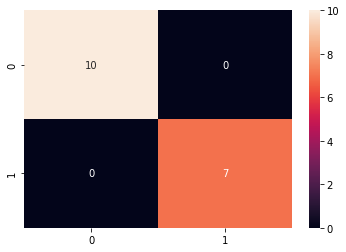

In [ ]:
#Hier werden die Labels der Daten vorbereitet
defects = {}

#Hier werden die Labels der Testdaten vorbereitet
y_test = np.zeros(len(test_image_path)) # y_test will be used for labels of test data
for idx, path in enumerate(test_image_path):
    defect = os.path.split(path)[1][:3] #first 3 letters of file names
    if defect == 'kor': # Code Anpassung für REM
        y_test[idx] = 2
    elif defect == 'duk':
        y_test[idx] = 1
    elif defect == 'spr':
        y_test[idx] = 0

print(image_path)

print("Genauigkeit = ", metrics.accuracy_score(y_test,prediction_RF))
cm=confusion_matrix(y_test,prediction_RF)
print("y_test",y_test)
print("prediction_RF",prediction_RF)
sns.heatmap(cm,annot=True)